In [51]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy as sp
from tqdm import tqdm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import imageio
from helpers import (Fy, find_closest_element, predict_single_density, compute_coverage, 
confidence_interval, confidence_interval, generate_fixed_terms, get_ci)

In [52]:
# read in val data
B_zeta = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/B_zeta_val.npy')
true_y = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [53]:
no_points = 500
p_y_y0, part_1, phi_1_z, grid = generate_fixed_terms(no_points, density)

## 1. VA + RIDGE + PRECISE

In [87]:
va_ridge_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Ridge/'
mu_t_va = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
beta = np.mean(mu_t_va[int(0.9*50000):50000,0:10], axis = 0)
tau_sq = np.mean(np.exp(mu_t_va[int(0.9*50000):50000,10]), axis = 0)
p = len(beta)
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [88]:
densities_va = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, None, 'va_ridge')
    densities_va.append(dens)

100%|██████████| 10472/10472 [00:26<00:00, 389.91it/s]


In [89]:
# mean prediction
pred_y_va_ridge = []
densities_va
for i in tqdm(range(0, B_zeta.shape[0])):
    y_i = sp.integrate.trapz(densities_va[i]*grid, grid)
    pred_y_va_ridge.append(y_i)
pred_y_va_ridge = np.array(pred_y_va_ridge)

100%|██████████| 10472/10472 [00:01<00:00, 7937.50it/s]


In [90]:
# variance prediction
pred_y_va_ridge_var = []
densities_va
for i in tqdm(range(0, B_zeta.shape[0])):
    y_i = sp.integrate.trapz(densities_va[i]*((grid - pred_y_va_ridge[i])**2), grid)
    pred_y_va_ridge_var.append(y_i)

100%|██████████| 10472/10472 [00:01<00:00, 7078.04it/s]


In [73]:
df_var = pd.DataFrame({'va_ridge': pred_y_va_ridge_var})

In [26]:
np.mean((true_y - np.array(pred_y_va_ridge))**2)

8.744420394774195

In [50]:
np.mean(np.abs(true_y - np.array(pred_y_va_ridge)) < 6)

0.37538197097020626

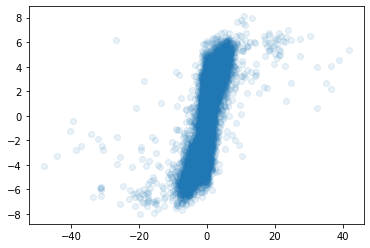

In [23]:
plt.scatter(true_y, np.array(pred_y_va_ridge), alpha = 0.1)

In [ ]:
## 2. VA + Horseshoe + PRECISE

In [74]:
va_horse_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/'
mu_t_va = np.load(va_horse_dir + 'mu_ts.npy').reshape(29001, 21)
beta = np.mean(mu_t_va[20000:,0:10], axis = 0)
Lambda = np.mean(np.exp(0.5*mu_t_va[20000:,10:20]), axis = 0)
tau_sq = np.exp(np.mean(mu_t_va[20000:,20], axis = 0))
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [75]:
densities_va = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, 'va_horseshoe')
    densities_va.append(dens)

100%|██████████| 10472/10472 [00:22<00:00, 460.31it/s]


In [76]:
pred_y_va_horse = []
densities_va
for i in tqdm(range(0, B_zeta.shape[0])):
    y_i = sp.integrate.trapz(densities_va[i]*grid, grid)
    pred_y_va_horse.append(y_i)

100%|██████████| 10472/10472 [00:01<00:00, 9309.82it/s]


In [77]:
# variance prediction
pred_y_va_horse_var = []
densities_va
for i in tqdm(range(0, B_zeta.shape[0])):
    y_i = sp.integrate.trapz(densities_va[i]*((grid - pred_y_va_horse[i])**2), grid)
    pred_y_va_horse_var.append(y_i)

100%|██████████| 10472/10472 [00:01<00:00, 7087.34it/s]


In [78]:
df_var['va_horse'] = pred_y_va_horse_var

In [34]:
np.mean((true_y - np.array(pred_y_va_horse))**2)

8.659875523054733

In [35]:
np.mean(np.abs((true_y - np.array(pred_y_va_horse))))

1.733507646501239

In [36]:
np.mean(np.abs(true_y - np.array(pred_y_va_horse)) < 6)

0.9766997708174179

# HMC + Ridge + Precise

In [79]:
hmc_ridge_dir = '../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/'
mu_t_hmc = np.load(hmc_ridge_dir + 'all_thetas.npy')[20000:,:]
beta = np.mean(mu_t_hmc[:,0:10], axis = 0)
tau_sq = np.exp(mu_t_hmc[:,10])
z_pred = B_zeta.reshape(B_zeta.shape[0], p).dot(beta)
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]

In [80]:
densities_va = []
for i in tqdm(range(0, B_zeta.shape[0])):
    dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, None, 'hmc_ridge')
    densities_va.append(dens)

100%|██████████| 10472/10472 [04:26<00:00, 39.24it/s]


In [82]:
pred_y_hmc_ridge = []
densities_va
for i in tqdm(range(0, B_zeta.shape[0])):
    y_i = sp.integrate.trapz(densities_va[i]*grid, grid)
    pred_y_hmc_ridge.append(y_i)

100%|██████████| 10472/10472 [00:01<00:00, 7491.99it/s]


In [83]:
# variance prediction
pred_y_hmc_ridge_var = []
densities_va
for i in tqdm(range(0, B_zeta.shape[0])):
    y_i = sp.integrate.trapz(densities_va[i]*((grid - pred_y_hmc_ridge[i])**2), grid)
    pred_y_hmc_ridge_var.append(y_i)

100%|██████████| 10472/10472 [00:01<00:00, 7785.26it/s]


In [84]:
df_var['hmc_ridge'] = pred_y_hmc_ridge_var

In [96]:
np.mean(np.array(pred_y_va_ridge_var) - np.array(pred_y_hmc_ridge_var))

0.012392181438635554

In [93]:
df_var.to_csv('densities_variance.csv', index = False)

In [46]:
# mse
np.mean((true_y - np.array(pred_y_hmc_horse))**2)

8.738404117276568

In [47]:
# mae
np.mean(np.abs((true_y - np.array(pred_y_hmc_horse))))

1.8200146720341996

In [48]:
# accuracy
np.mean(np.abs(true_y - np.array(pred_y_hmc_horse)) < 6)

0.9806149732620321